# Multi modal model

In [ ]:
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning

In [131]:
import yfinance as yf
import numpy as np
import pandas as pd
import glob
import re
import nltk
import nest_asyncio
import matplotlib.pyplot as plt

from calendar import monthrange
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
from datetime import datetime, timedelta, date
import pytz
import torch
import torch.nn as nn
import torch.utils.data as td
import sklearn
import pytorch_lightning as pl
from typing import List, Optional

from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Fetch financial record from 1st January 2015 - 31st May 2021

In [10]:
start_date ='2015-01-01'
end_date = '2021-05-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Compute Lagged price

In [ ]:
price.head()    

In [12]:
# Due to the high volatility nature of crypto currency we chose a 1 day lag

lag = 1  # Number of lags
price['Close Lagged Price'] = price['Close'].shift(lag)

In [13]:
price.head()

,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price
Date,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,264.195007


In [14]:
price.shape

(2342, 7)

# Compute moving average

In [15]:
# We will compute 7, 14, 21 simple moving average moving average 

price['sma7'] = price['Close'].rolling(window=7).mean()
price['sma14'] = price['Close'].rolling(window=14).mean()
price['sma21'] = price['Close'].rolling(window=21).mean()


price['ema12'] = price['Close'].ewm(span=12, adjust=False).mean()
price['ema26'] = price['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
price['MACD line'] = price['ema12'] - price['ema26']

# Calculate Signal Line
price['Signal line'] = price['MACD line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
price['MACD histogram'] = price['MACD line'] - price['Signal line']


In [ ]:
price.head()

In [17]:
price.shape

(2342, 15)

In [18]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [19]:
price.shape

(2342, 16)

In [ ]:
price.tail(5)

In [21]:
price.dropna()

,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
Date,,,,,,,,,,,,,,,,
2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
2015-01-22,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,226.897003,214.882143,229.760211,248.347666,228.736136,251.162887,-22.426751,-22.925908,0.499157,37.948058
2015-01-23,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,233.406006,218.422429,225.650998,244.435617,229.373500,249.808525,-20.435025,-22.427731,1.992706,35.665555
2015-01-24,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,232.878998,225.363429,223.726070,242.852998,232.215577,249.663227,-17.447650,-21.431715,3.984065,43.263526
2015-01-25,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,247.847000,231.560429,222.873070,242.354093,235.523642,249.963581,-14.439938,-20.033360,5.593421,46.965307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26,38392.625000,40782.078125,37905.835938,39294.199219,39294.199219,51346735160,38402.222656,38113.863839,41647.098214,46455.394903,41038.820893,45730.196464,-4691.375571,-4177.557784,-513.817788,33.003717
2021-05-27,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,43210968721,39294.199219,37778.753906,40841.439453,45600.178385,40638.535948,45189.957374,-4551.421426,-4252.330512,-299.090914,30.743726
2021-05-28,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,55200191952,38436.968750,37549.170201,39828.373047,44568.807106,39878.392797,44486.820196,-4608.427399,-4323.549889,-284.877509,27.743299


In [23]:
price.isnull().value_counts()

Open   High   Low    Close  Adj Close  Volume  Close Lagged Price  sma7   sma14  sma21  ema12  ema26  MACD line  Signal line  MACD histogram  rsi  
False  False  False  False  False      False   False               False  False  False  False  False  False      False        False           False    2322
                                                                                 True   False  False  False      False        False           False       7
                                                                          True   True   False  False  False      False        False           True        7
                                                                   True   True   True   False  False  False      False        False           True        5
                                               True                True   True   True   False  False  False      False        False           True        1
Name: count, dtype: int64

In [ ]:
price.describe()

In [ ]:
price.info()

<Figure size 1200x600 with 0 Axes>

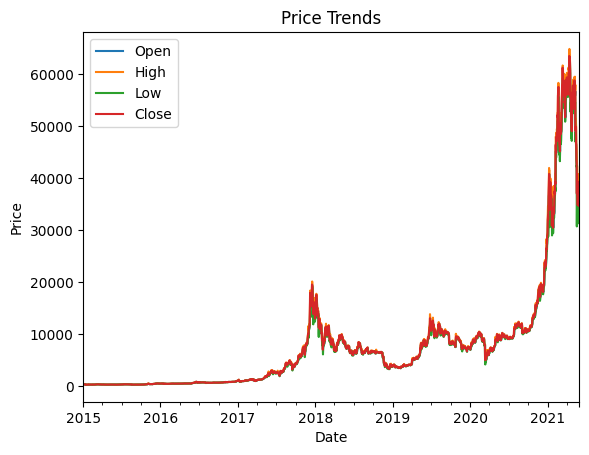

In [26]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

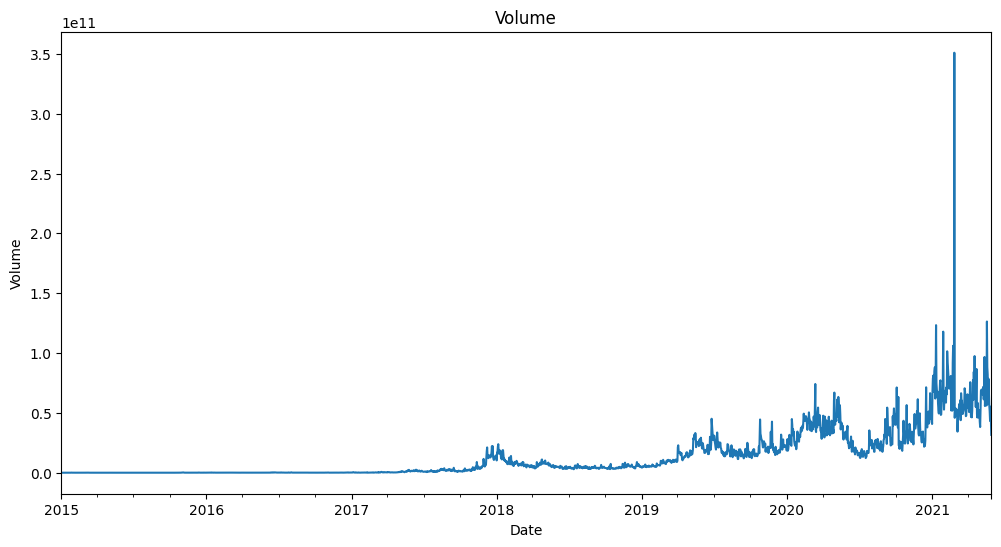

In [27]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

<Figure size 1200x600 with 0 Axes>

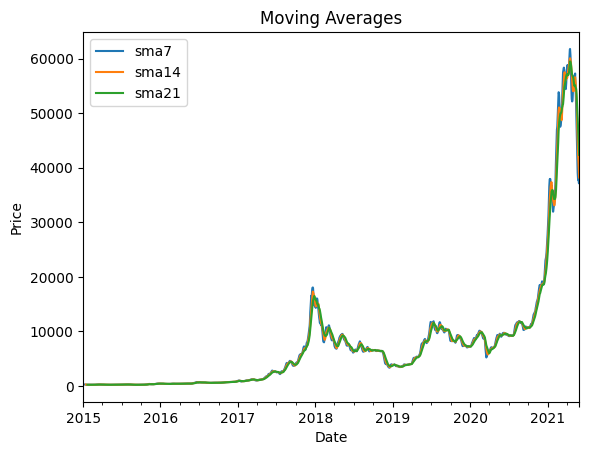

In [28]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

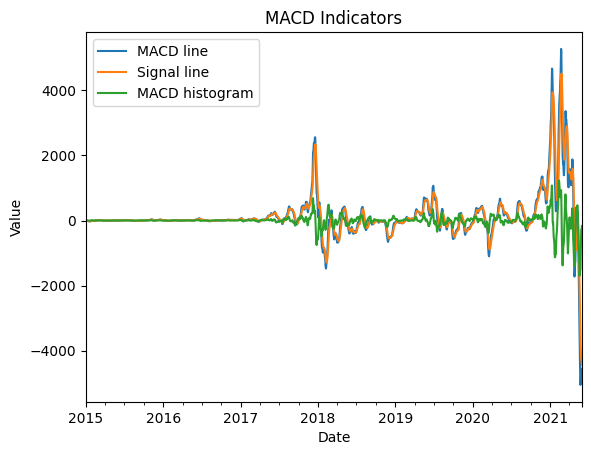

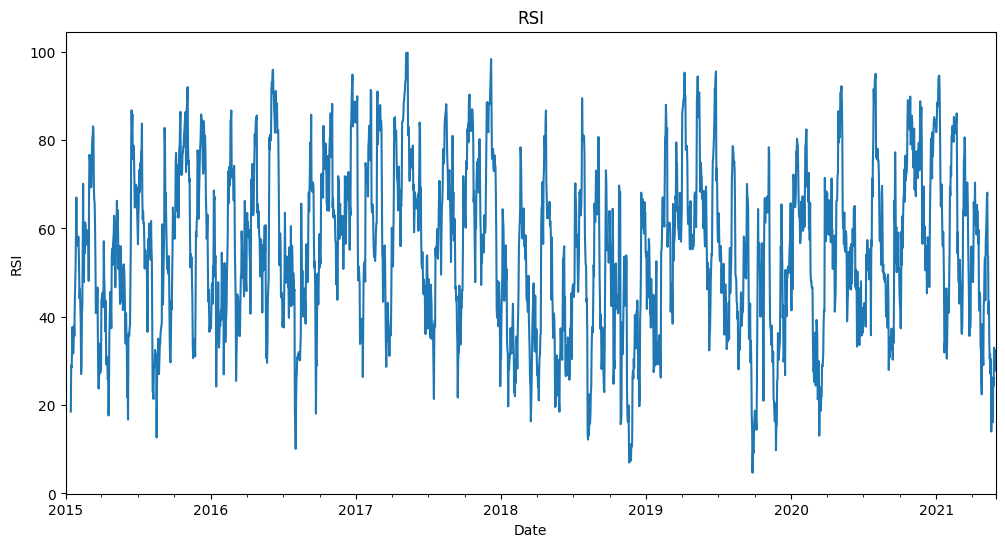

In [29]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

# Process financial article

In [35]:
from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from nltk.stem import WordNetLemmatizer,PorterStemmer

In [ ]:
nltk.download('stopwords')

stop=set(stopwords.words('english'))

In [37]:
# Import packages
# Default packages
import time
import csv
import os
import json


# Preinstalled packages
import requests
import pandas as pd

# URL of our News API
base_url = 'https://api.newscatcherapi.com/v2/search?lang=en'

# Your API key
X_API_KEY = 'YHBKmAH0DbzXSs_h7be46br_kfw3EhBcqXPtCTSg1Qc'

In [52]:
# Put your API key to headers in order to be authorized to perform a call
headers = {'x-api-key': X_API_KEY}
# Define your desired parameters
# params = [
#     {
#         'q': 'Bitcoin',
#         'lang': 'en',
#         'to_rank': 10000,
#         'topic': "business",
#         'page_size': 100,
#         'page': 1,
#         'from' : "2015/01/01",
#         'to': "2019/12/31"
#     }
# ]

params = [
    {
        'q': 'Bitcoin',
        'lang': 'en',
        'to_rank': 10000,
        'topic': "business",
        'page_size': 100,
        'page': 1
    }
]



In [53]:
# Variable to store all found news articles, mp stands for "multiple queries"
all_news_articles_mp = []

# Infinite loop which ends when all articles are extracted
for separated_param in params:

    print(f'Query in use => {str(separated_param)}')
    
    while True:
        # Wait for 1 second between each call
        time.sleep(1)

        # GET Call from previous section enriched with some logs
        response = requests.get(base_url, headers=headers, params=separated_param)
        results = json.loads(response.text.encode())
        if response.status_code == 200:
            print(f'Done for page number => {separated_param["page"]}')


            # Adding your parameters to each result to be able to explore afterwards
            for i in results['articles']:
                i['used_params'] = str(separated_param)


            # Storing all found articles
            all_news_articles_mp.extend(results['articles'])

            # Ensuring to cover all pages by incrementing "page" value at each iteration
            separated_param['page'] += 1
            if separated_param['page'] > results['total_pages']:
                print("All articles have been extracted")
                break
            else:
                print(f'Proceed extracting page number => {separated_param["page"]}')
        else:
            print(results)
            print(f'ERROR: API call failed for page number => {separated_param["page"]}')
            break

Query in use => {'q': 'Bitcoin', 'lang': 'en', 'to_rank': 10000, 'topic': 'business', 'page_size': 100, 'page': 1}
Done for page number => 1
All articles have been extracted


In [54]:
print(f'Number of extracted articles => {str(len(all_news_articles_mp))}')

Number of extracted articles => 89


In [55]:
# Define variables
unique_ids = []
all_news_articles = []

# Iterate on each article and check whether we saw this _id before
for article in all_news_articles_mp:
    if article['_id'] not in unique_ids:
        unique_ids.append(article['_id'])
        all_news_articles.append(article)

In [56]:
# Import data into pandas
pandas_table = pd.DataFrame(all_news_articles)

In [ ]:
pandas_table.head()

In [58]:
news_2013_2017 = pd.read_csv("../archive/crypto_news_parsed_2013-2017_train.csv")
news_2018 = pd.read_csv("../archive/crypto_news_parsed_2018_validation.csv")


In [60]:
frames = [news_2013_2017,news_2018]
news = pd.concat(frames,ignore_index=True)

In [62]:
def find_date_from_html(year, html):
    date_regex = str(year) + r'[-/](\d{2})[-/](\d{2})'
    date_matches = re.findall(date_regex,html)
    date_matches = [(int(m),int(d)) for m,d in date_matches if int(m) < 13 and int(d) <= monthrange(int(year), int(m))[1] and int(d) > 0 and int(m) > 0]
    if not date_matches:
        return (None, None)
    return max(set(date_matches), key=date_matches.count)

In [74]:

date=[]
count=0
for i in range(0,len(news)):
    date.append(find_date_from_html(news['year'][i],news['url'][i]))
    if date[i] == (None,None):
        count+=1

In [75]:
count

29795

In [ ]:
news[["month", "day"]] = news.apply(lambda x: find_date_from_html(x["year"], x["html"]), axis=1, result_type='expand')
news['date'] = pd.to_datetime(news[["year", "month", "day"]], utc=True)
news = news.drop(columns=["year", "month", "day"])
#news = news.set_index("date")
news.dropna()

In [79]:
len(news)

39308

In [80]:
news=news[news['date'].isna()!=True]

In [81]:
len(news)

15350

In [ ]:
news['date']

In [86]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
news['title']=news['title'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
news['title']=news['title'].apply(lambda x:remove_html(x))

In [85]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
news['title']=news['title'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
news['title']=news['title'].apply(lambda x:remove_num(x))

In [84]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
news['title']=news['title'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
news['title']=news['title'].apply(lambda x:remove_stopwords(x))

In [83]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
news['title']=news['title'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
news['title']=news['title'].apply(lambda x:remove_hash(x))

In [87]:
#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
def stemming(text):
    ps = PorterStemmer()
    
    return" ".join([ps.stem(word) for word in str(text).split()])
    
def lemmatizing(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    return" ".join([wordnet_lemmatizer.lemmatize(word) for word in str(text).split()])
news['title']=news['title'].apply(lambda x:remove_space(x))

In [88]:
from collections import Counter
comment_words = '' 
stopwords = set(STOPWORDS) 

for val in news.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
split_it = comment_words.split()
Counter = Counter(split_it)
number=20
most_occur = Counter.most_common(number)
most_occur

[('bitcoin', 6994),
 ('price', 5112),
 ('analysis', 3513),
 ('technical', 1946),
 ('ethereum', 1446),
 ('watch', 1200),
 ('blockchain', 1169),
 ('crypto', 885),
 ('the', 847),
 ('cryptocurrency', 698),
 ('new', 595),
 ('btc', 563),
 ('ethusd', 537),
 ('trading', 498),
 ('exchange', 491),
 ('cash', 481),
 ('litecoin', 470),
 ('to', 455),
 ('ripple', 414),
 ('tech', 406)]

<Axes: xlabel='Word'>

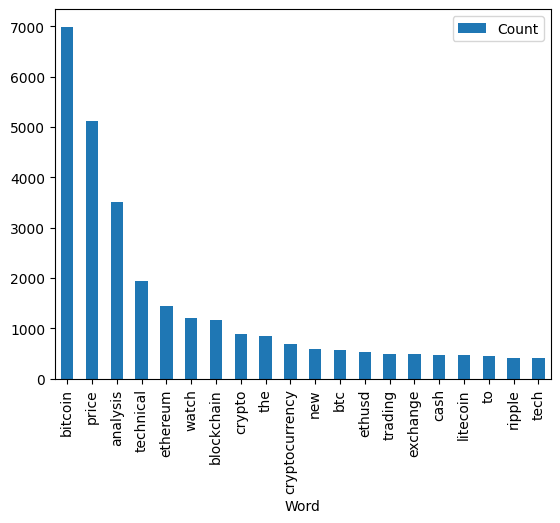

In [89]:
dfm = pd.DataFrame(most_occur, columns = ['Word', 'Count'])
dfm.plot.bar(x='Word',y='Count')

In [90]:
news['title']=news['title'].apply(lambda x:stemming(x))

# Sentiment Analysis on news artciles

In [ ]:
df=pd.read_csv('cryptonews.csv')
df.head()

In [115]:
df=df[['text','sentiment']]
df.loc[df['sentiment'].str.contains('positive'), 'sentiment'] = 'positive'
df.loc[df['sentiment'].str.contains('negative'), 'sentiment'] = 'negative'
df.loc[df['sentiment'].str.contains('neutral'), 'sentiment'] = 'neutral'
df.rename(columns = {'text':'headline',"sentiment":"Label"}, inplace = True)
df.head()

,headline,Label
0,With a roster full of entertainment industry n...,positive
1,Blockchain analytics firm Nansen has released ...,negative
2,The hardware wallet firm is certain that the l...,positive
3,"Kyle Davies, founder of the collapsed crypto f...",neutral
4,Despite the ongoing crypto market downturn whi...,positive


In [117]:
train =  df.iloc[:10000,:]
test =  df.iloc[:10000,:]

In [118]:
# Drop duplicates
df.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (12750, 2)


In [119]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)


Null Values in each column:
    column name  Total missing  Percent missing
0     headline              0              0.0
1        Label              0              0.0


In [120]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['Label']==target ]['headline'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
np.array(stop)

In [122]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['headline']=df['headline'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['headline']=df['headline'].apply(lambda x:remove_html(x))



In [123]:

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['headline']=df['headline'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['headline']=df['headline'].apply(lambda x:remove_num(x))



In [124]:

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['headline']=df['headline'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['headline']=df['headline'].apply(lambda x:remove_stopwords(x))



In [125]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['headline']=df['headline'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['headline']=df['headline'].apply(lambda x:remove_hash(x))


In [126]:

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
def stemming(text):
    ps = PorterStemmer()
    
    return" ".join([ps.stem(word) for word in str(text).split()])
    
def lemmatizing(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    
    return" ".join([wordnet_lemmatizer.lemmatize(word) for word in str(text).split()])
df['headline']=df['headline'].apply(lambda x:remove_space(x))





In [128]:
df

,headline,Label
0,roster full entertainment industry notables ae...,positive
1,blockchain analytics firm nansen released over...,negative
2,hardware wallet firm certain latest uptick dem...,positive
3,kyle davies founder collapsed crypto fund thre...,neutral
4,despite ongoing crypto market downturn intensi...,positive
...,...,...
12745,cream finance cream suffered another flash loa...,neutral
12746,banque de france disclosed results experimenta...,positive
12747,advancing project become xcaâxametaverseâxacom...,positive
12748,chinese companies still topping blockchain pat...,neutral


In [129]:
countvector=CountVectorizer(ngram_range=(2,2))
traindataset=countvector.fit_transform(train['headline'].tolist())

In [132]:
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(traindataset,train['Label'])

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [134]:
## Predict for the Test Dataset
test_dataset = countvector.transform(test['headline'].tolist())
predictions = randomclassifier.predict(test_dataset)

In [137]:
new_dataset = countvector.transform(news['title'].tolist())

In [138]:
predictions = randomclassifier.predict(new_dataset)

In [151]:
news['title'][5]

'key bitcoin price level week dec my trade plan'

In [145]:
# Load the model from the file
sentiment_model = joblib.load('sentiment_model.pkl')
  

In [146]:
k = sentiment_model.predict(new_dataset)

In [152]:
k[5]

'neutral'

In [112]:
sentiment_model.fit()

MultinomialNB()

In [ ]:

# Use the loaded model to make predictions
news['sentiment'] = sentiment_model.predict(new_dataset)

# Process tweets

In [86]:
tweets_2015 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')


In [87]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [151]:
tweets['Date'] = tweets['date']

In [155]:
tweets = tweets.drop(columns=['date', 'label_up5','label_up2','label_down5','label_down2'])

In [156]:
tweets.shape

(342062, 3)

In [157]:
tweets.tail()

,Unnamed: 0,text_split,Date
342057,31805,bitcoin claim free bitcoin bitcoin price sugge...,2021-05-31
342058,31806,het roulette het is wat of twitter deal gift s...,2021-05-31
342059,31807,longer it stays in this range it will be it go...,2021-05-31
342060,31808,en el video para el de media el de en ya para ...,2021-05-31
342061,31809,you are pleb and bitcoin don have boss mi btc ...,2021-05-31


In [158]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,NaN,NaN,314.248993,314.248993,0.000000,0.000000,0.000000,NaN
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993,NaN,NaN,NaN,314.369458,314.306994,0.062463,0.012493,0.049971,NaN
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013,NaN,NaN,NaN,309.248310,311.845884,-2.597573,-0.509521,-2.088053,NaN
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001,NaN,NaN,NaN,302.317033,308.316189,-5.999156,-1.607448,-4.391709,NaN
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,264.195007,NaN,NaN,NaN,298.033489,305.809360,-7.775871,-2.841132,-4.934739,NaN


In [159]:
price=price.reset_index()
price['Date']=price.Date.apply (lambda x : str(x)[:10])

In [160]:
price.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
0,0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,NaN,NaN,314.248993,314.248993,0.000000,0.000000,0.000000,NaN
1,1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,314.248993,NaN,NaN,NaN,314.369458,314.306994,0.062463,0.012493,0.049971,NaN
2,2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,315.032013,NaN,NaN,NaN,309.248310,311.845884,-2.597573,-0.509521,-2.088053,NaN
3,3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,281.082001,NaN,NaN,NaN,302.317033,308.316189,-5.999156,-1.607448,-4.391709,NaN
4,4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,264.195007,NaN,NaN,NaN,298.033489,305.809360,-7.775871,-2.841132,-4.934739,NaN


In [ ]:
tweets

In [161]:
price_tweets = tweets.merge(price, how='outer', on=['Date'])

In [ ]:
price_tweets.head()

In [199]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342158 entries, 0 to 342157
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          342062 non-null  float64
 1   text_split          342062 non-null  object 
 2   Date                342158 non-null  object 
 3   index               341961 non-null  float64
 4   Open                341961 non-null  float64
 5   High                341961 non-null  float64
 6   Low                 341961 non-null  float64
 7   Close               341961 non-null  float64
 8   Adj Close           341961 non-null  float64
 9   Volume              341961 non-null  float64
 10  Close Lagged Price  341897 non-null  float64
 11  sma7                341505 non-null  float64
 12  sma14               341034 non-null  float64
 13  sma21               340455 non-null  float64
 14  ema12               341961 non-null  float64
 15  ema26               341961 non-nul

# Process news article

In [233]:
news = pd.read_csv('../msc/archive/data/cryptonews_processed_2013_2022.csv')

In [165]:
news.head()

,date,sentiment,title
0,2013-01-01 00:00:00+00:00,neutral,bitcoin exchange btc china temporarily halts t...
1,2013-01-01 00:00:00+00:00,neutral,happened us regulators bitcoin meeting
2,2013-01-02 00:00:00+00:00,positive,vault satoshi expands canadian bitcoin exchang...
3,2013-01-22 00:00:00+00:00,positive,gambling bitcoin block chain
4,2013-01-26 00:00:00+00:00,neutral,bitmarkers wants move money bitcoin incasino g...


In [234]:
news = news.rename(columns = {'date':'Date', 'title': 'article'})

In [235]:
news = news.drop(columns=['sentiment'])

In [236]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28100 entries, 0 to 28099
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     28100 non-null  object
 1   article  28100 non-null  object
dtypes: object(2)
memory usage: 439.2+ KB


In [220]:
news.head()

,Date,article
0,2013-01-01 00:00:00+00:00,bitcoin exchange btc china temporarily halts t...
1,2013-01-01 00:00:00+00:00,happened us regulators bitcoin meeting
2,2013-01-02 00:00:00+00:00,vault satoshi expands canadian bitcoin exchang...
3,2013-01-22 00:00:00+00:00,gambling bitcoin block chain
4,2013-01-26 00:00:00+00:00,bitmarkers wants move money bitcoin incasino g...


In [242]:
news['Date'] = pd.to_datetime(news.Date,utc=True,format='%Y/%m/%d')

In [246]:
news['Date']=news['Date'].dt.strftime('%Y-%m-%d')

In [247]:
news

,Date,article
0,2013-01-01,bitcoin exchange btc china temporarily halts t...
1,2013-01-01,happened us regulators bitcoin meeting
2,2013-01-02,vault satoshi expands canadian bitcoin exchang...
3,2013-01-22,gambling bitcoin block chain
4,2013-01-26,bitmarkers wants move money bitcoin incasino g...
...,...,...
28095,2021-10-27,cream financ cream suffer anoth flash loan attack
28096,2021-10-19,banqu de franc disclos result experiment progr...
28097,2021-10-18,advanc project becom xcaâxametaverseâxacompany...
28098,2021-10-15,chines compani still top blockchain patent chart


In [249]:
price_tweets_news = news.merge(price_tweets, how='outer', on=['Date'])

In [252]:
price_tweets_news.shape

(1812331, 21)

In [255]:
price_tweets_news.dropna()

,Date,article,Unnamed: 0,text_split,index,Open,High,Low,Close,Adj Close,...,Close Lagged Price,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,rsi
8660,2015-01-21,bitcoin trader gets fouryear jail term silk ro...,1506.0,un pone bitcoin to silk road ross was back in ...,20.0,211.378006,227.787994,211.212006,226.897003,226.897003,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
8661,2015-01-21,bitcoin trader gets fouryear jail term silk ro...,1507.0,free here in just up for early access to debit...,20.0,211.378006,227.787994,211.212006,226.897003,226.897003,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
8662,2015-01-21,bitcoin trader gets fouryear jail term silk ro...,1508.0,market via major financial and get together to...,20.0,211.378006,227.787994,211.212006,226.897003,226.897003,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
8663,2015-01-21,bitcoin trader gets fouryear jail term silk ro...,1509.0,buy sell bitcoin btc site web love hope to hel...,20.0,211.378006,227.787994,211.212006,226.897003,226.897003,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
8664,2015-01-21,bitcoin trader gets fouryear jail term silk ro...,1510.0,bitcoin ask bitcoin unbreakable coin video of ...,20.0,211.378006,227.787994,211.212006,226.897003,226.897003,...,211.315002,211.516142,233.327568,252.197332,227.887069,252.583438,-24.696369,-23.050697,-1.645671,34.070140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591026,2018-11-13,bitcoin price watch heres whats morning,59334.0,affiliate or even lower then some other bitcoi...,1412.0,6373.189941,6395.270020,6342.669922,6359.490234,6359.490234,...,6371.270020,6417.247280,6401.615723,6414.436663,6405.482128,6428.360042,-22.877914,-22.623520,-0.254394,52.494579
1591027,2018-11-13,bitcoin price watch heres whats morning,59335.0,have you into that one curious about your take...,1412.0,6373.189941,6395.270020,6342.669922,6359.490234,6359.490234,...,6371.270020,6417.247280,6401.615723,6414.436663,6405.482128,6428.360042,-22.877914,-22.623520,-0.254394,52.494579
1591028,2018-11-13,bitcoin price watch heres whats morning,59336.0,come true la bitcoin cash association la de en...,1412.0,6373.189941,6395.270020,6342.669922,6359.490234,6359.490234,...,6371.270020,6417.247280,6401.615723,6414.436663,6405.482128,6428.360042,-22.877914,-22.623520,-0.254394,52.494579
1591029,2018-11-13,bitcoin price watch heres whats morning,59337.0,problem bitcoin medium of exchange nobody it a...,1412.0,6373.189941,6395.270020,6342.669922,6359.490234,6359.490234,...,6371.270020,6417.247280,6401.615723,6414.436663,6405.482128,6428.360042,-22.877914,-22.623520,-0.254394,52.494579


In [254]:
price_tweets_news.shape

(1812331, 21)

In [9]:
#now let's try to split the text into smaller chunks, which is just taking the tutorial's code
def get_split(text1,length=200, overlap=50):
  l_total = []
  l_parcial = []
  if len(text1.split())//(length-overlap) >0:
    n = len(text1.split())//(length-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:length]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*(length-overlap):w*(length-overlap) + length]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
#next, tie them up, read in csv, combine into chunks, take the dates as the price? 
path = '../archive/data/tweets'
all_files = glob.glob(path+'/*.csv')

#let me try to use list1 to store string and list 2 to store dates
li1=[]
li2=[]
for file in all_files:
  df=pd.read_csv(file,sep=',',index_col=0)
  df=df['text'].to_frame()
  rawtxt=[]
  for row in df.text:
    rawtxt.append(row)
  string = " ".join(rawtxt)

  date= file[-14:-4]
  
  li1.append(string)
  li2.append(date)

data=pd.DataFrame({'date':li2, 'text':li1})



In [3]:
start_date ='2018-12-28'
end_date = '2019-04-02'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
price.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701,3923.918701,5631554348
2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691,3820.408691,4991655917
2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637,3865.952637,4770578575
2018-12-31,3866.839111,3868.742920,3725.867432,3742.700439,3742.700439,4661840806
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990


In [5]:
price_2= price.Close.to_frame()
price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0)
price=price.reset_index()
price['date']=price.Date.apply (lambda x : str(x)[:10])

In [6]:
price.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label,date
0,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701,3923.918701,5631554348,NaN,NaN,False,2018-12-28
1,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691,3820.408691,4991655917,-0.026379,-0.026733,False,2018-12-29
2,2018-12-30,3822.384766,3901.908936,3797.219238,3865.952637,3865.952637,4770578575,0.011921,0.011851,True,2018-12-30
3,2018-12-31,3866.839111,3868.742920,3725.867432,3742.700439,3742.700439,4661840806,-0.031881,-0.032401,False,2018-12-31
4,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990,0.026938,0.026581,True,2019-01-01
5,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836,0.025989,0.025657,True,2019-01-02
6,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219,-0.027050,-0.027422,False,2019-01-03
7,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467,0.005467,0.005452,True,2019-01-04
8,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5137609824,-0.003246,-0.003251,False,2019-01-05
9,2019-01-06,3836.519043,4093.297363,3826.513184,4076.632568,4076.632568,5597027440,0.060189,0.058447,True,2019-01-06


In [8]:
tweets = pd.read_csv("../msc/archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv")

In [9]:
tweets.head(5)

,Unnamed: 0,date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2019-04-01,btc bitcoin current price more on food for tho...,False,False,False,False
1,1,2019-04-01,reveal is relevant in billion dollar bitcoin l...,False,False,False,False
2,2,2019-04-01,to year of crypto research and chance to win b...,False,False,False,False
3,3,2019-04-01,off is the solution appreciate that man there ...,False,False,False,False
4,4,2019-04-01,ratio buy at and sell at ratio bitcoin the onl...,False,False,False,False


In [10]:
tweets = tweets[['date', 'text_split']]

In [11]:
tweets.head()

,date,text_split
0,2019-04-01,btc bitcoin current price more on food for tho...
1,2019-04-01,reveal is relevant in billion dollar bitcoin l...
2,2019-04-01,to year of crypto research and chance to win b...
3,2019-04-01,off is the solution appreciate that man there ...
4,2019-04-01,ratio buy at and sell at ratio bitcoin the onl...


In [ ]:
tweets['text_split'][0]

In [14]:
frame_x = tweets.merge(price, how='outer', on=['date'])

In [17]:
frame_x.head()

,date,text_split,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label
0,2019-04-01,btc bitcoin current price more on food for tho...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
1,2019-04-01,reveal is relevant in billion dollar bitcoin l...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
2,2019-04-01,to year of crypto research and chance to win b...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
3,2019-04-01,off is the solution appreciate that man there ...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
4,2019-04-01,ratio buy at and sell at ratio bitcoin the onl...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True


In [18]:
frame_x.dropna()

,date,text_split,Date,Open,High,Low,Close,Adj Close,Volume,change,log_change,change_label
0,2019-04-01,btc bitcoin current price more on food for tho...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
1,2019-04-01,reveal is relevant in billion dollar bitcoin l...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
2,2019-04-01,to year of crypto research and chance to win b...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
3,2019-04-01,off is the solution appreciate that man there ...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
4,2019-04-01,ratio buy at and sell at ratio bitcoin the onl...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
...,...,...,...,...,...,...,...,...,...,...,...,...
264,2019-04-01,of just posted new valor em bitcoin ser no arr...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
265,2019-04-01,de tu bien lo ha roger massive bitcoin exchang...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
266,2019-04-01,bitcoin faucet with difference you decide how ...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True
267,2019-04-01,real again to make crypto great again to all p...,2019-04-01,4105.362305,4164.953125,4096.901367,4158.183105,4158.183105,1.015779e+10,0.012856,0.012774,True


In [72]:
df = pd.read_csv('../msc/archive/data/tweets/combined_tweets_2015_labeled.csv')

In [74]:
df.head()

,Unnamed: 0,date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
1,1,2015-01-01,accept here is bitcoin tip via claim it here c...,False,False,False,False
2,2,2015-01-01,btc bitcoin current price btc bitcoin parking ...,False,False,False,False
3,3,2015-01-01,revolution don miss out your bitcoin tip about...,False,False,False,False
4,4,2015-01-01,cap billion based on bitcoin informative my da...,False,False,False,False


In [73]:
df.shape

(28126, 7)

In [79]:
df = df['text_split'].to_frame()